<a href="https://colab.research.google.com/github/KevinGuzm/ProyectoSeriedeTiempo/blob/main/Fundamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion Temporales 

## **1. Carga de paquetes y datos**






In [ ]:
import pandas as pd
import numpy as np 
import math  
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Series de Tiempo/Desempleo y empleo/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


## **2. Tendencia y Estacionalidad**

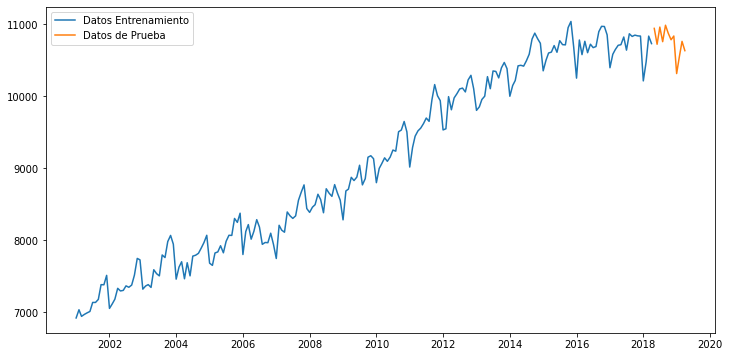

In [ ]:
train_len = 208 #Split de datos 
data_train = data[["Ocupados"]][:train_len].copy() 
data_test = data[["Ocupados"]][train_len:].copy() 

fig = plt.figure(figsize=(12, 6))
plt.plot(data_train,label="Datos Entrenamiento")
plt.plot(data_test,label="Datos de Prueba")
plt.legend()
plt.show()

In [ ]:
y = data_train["Ocupados"]
x = np.linspace(1, data_train.shape[0], data_train.shape[0])

month_dummies = pd.get_dummies(data_train.index.month, drop_first=True).set_index(data_train.index)

RMSE_list = []
for i in range(2, 8):
    data_train[f"x{i}"] = x**i
    X = sm.add_constant(pd.concat([data_train[[f"x{j}" for j in range(2, i+1)]], month_dummies], axis=1))
    season_pol = sm.OLS(y, X)
    season_pol_fit = season_pol.fit()
    y_pred = season_pol_fit.predict(X)
    RMSE = np.sqrt(mean_squared_error(y, y_pred))
    RMSE_list.append({"RMSE": RMSE, "Polinomio": i})

df = pd.DataFrame(RMSE_list)
df #el mejor modelo que reduce el RMSE es el polinomio de grado 6


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  else:
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  else:
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  else:
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  else:
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  e

,RMSE,Polinomio
0,371.530109,2
1,147.335902,3
2,139.100863,4
3,132.671200,5
4,116.393323,6
5,1738.881270,7


In [ ]:
y = data_train["Ocupados"]
x = np.linspace(1,data_train.shape[0],data_train.shape[0])
data_train["x"] = np.linspace(1,data_train.shape[0],data_train.shape[0])
data_train["x2"] = x**2
data_train["x3"] = x**3
data_train["x4"] = x**4
data_train["x5"] = x**5
data_train["x6"] = x**6


month_dummies = pd.get_dummies(data_train.index.month,drop_first=True).set_index(data_train.index)
X = sm.add_constant( pd.concat([data_train[["x","x2","x3","x4","x5","x6"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  else:


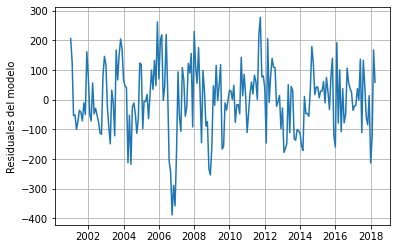

In [ ]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()

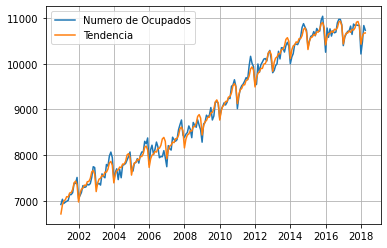

In [ ]:
plt.plot(y,label="Numero de Ocupados")
plt.plot(season_pol_2.fittedvalues,label="Tendencia")
plt.legend()
plt.grid()
plt.show()

### 2.1. Supuestos

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

def check_regression_assumptions(residuals):
   
    # Supuesto 1: Normalidad de los residuales
    sns.distplot(residuals)
    plt.title("Gráfico de distribución de los residuales")
    plt.xlabel("Residuales")
    plt.ylabel("Densidad")
    plt.show()
    
    # Supuesto 2: Homocedasticidad de los residuales
    plt.scatter(residuals.index, residuals)
    plt.title("Gráfico de dispersión de los residuales")
    plt.xlabel("Index")
    plt.ylabel("Residuales")
    plt.show()
    
    # Supuesto 3: Independencia de los residuales
    fig, ax = plt.subplots(figsize=(12,4))
    plot_lags = 40
    sm.graphics.tsa.plot_acf(residuals, lags=plot_lags, ax=ax)
    plt.title("Función de autocorrelación de los residuales")
    plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


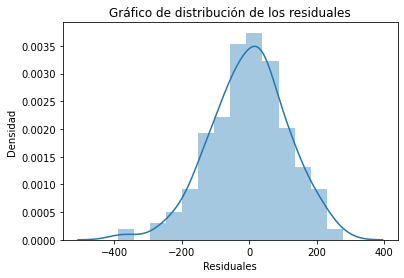

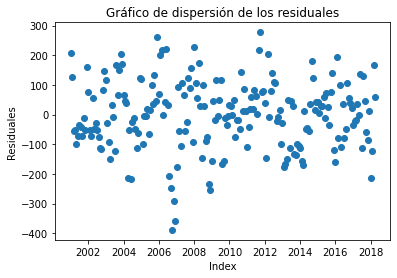

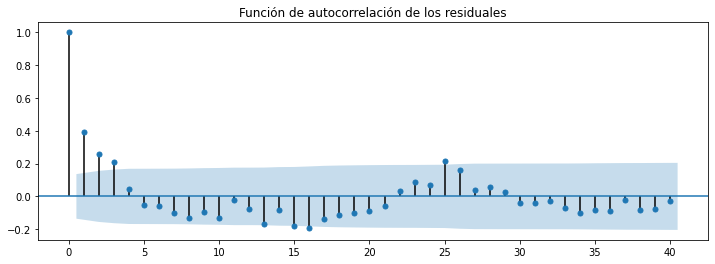

In [ ]:
supuestos= check_regression_assumptions(season_pol_2.resid)

In [ ]:
from statsmodels.stats.stattools import durbin_watson

def check_independence(residuals):
    dw_test = durbin_watson(residuals)
    return dw_test

dw_test = check_independence(season_pol_2.resid)
dw_test 
# Un valor cercano a 2 indica que no hay autocorrelación y un valor cercano a 0 o 4 indica autocorrelación


1.1925282407953335

In [ ]:
h=12
x_for= np.linspace((data_train.shape[0]+1),(data_train.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2,x_for**3,x_for**4,x_for**5,x_for**6),axis=1),columns=["x","x2","x3","x4","x5","x6"] )

range_dates = pd.date_range(data_train.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  else:


,const,x,x2,x3,x4,x5,x6,2,3,4,5,6,7,8,9,10,11,12
0,1.0,209.0,43681.0,9129329.0,1.908030e+09,3.987782e+11,8.334465e+13,0,0,0,1,0,0,0,0,0,0,0
1,1.0,210.0,44100.0,9261000.0,1.944810e+09,4.084101e+11,8.576612e+13,0,0,0,0,1,0,0,0,0,0,0
2,1.0,211.0,44521.0,9393931.0,1.982119e+09,4.182272e+11,8.824594e+13,0,0,0,0,0,1,0,0,0,0,0
3,1.0,212.0,44944.0,9528128.0,2.019963e+09,4.282322e+11,9.078522e+13,0,0,0,0,0,0,1,0,0,0,0
4,1.0,213.0,45369.0,9663597.0,2.058346e+09,4.384277e+11,9.338511e+13,0,0,0,0,0,0,0,1,0,0,0
5,1.0,214.0,45796.0,9800344.0,2.097274e+09,4.488166e+11,9.604674e+13,0,0,0,0,0,0,0,0,1,0,0
6,1.0,215.0,46225.0,9938375.0,2.136751e+09,4.594014e+11,9.877130e+13,0,0,0,0,0,0,0,0,0,1,0
7,1.0,216.0,46656.0,10077696.0,2.176782e+09,4.701850e+11,1.015600e+14,0,0,0,0,0,0,0,0,0,0,1
8,1.0,217.0,47089.0,10218313.0,2.217374e+09,4.811701e+11,1.044139e+14,0,0,0,0,0,0,0,0,0,0,0
9,1.0,218.0,47524.0,10360232.0,2.258531e+09,4.923597e+11,1.073344e+14,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
dt = season_pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01    10722.875411  10451.615719  10994.135103
2018-06-01    10697.118462  10418.863782  10975.373141
2018-07-01    10768.768743  10482.142822  11055.394664
2018-08-01    10760.110701  10463.590308  11056.631094
2018-09-01    10817.048600  10508.967763  11125.129437
2018-10-01    10948.870589  10627.427423  11270.313755
2018-11-01    10974.969360  10638.234737  11311.703983
2018-12-01    10885.054801  10530.981972  11239.127630
2019-01-01    10502.760546  10130.423582  10875.097509
2019-02-01    10690.073089  10295.767813  11084.378366
2019-03-01    10772.018977  10353.391961  11190.645994
2019-04-01    10793.847207  10348.459930  11239.234484


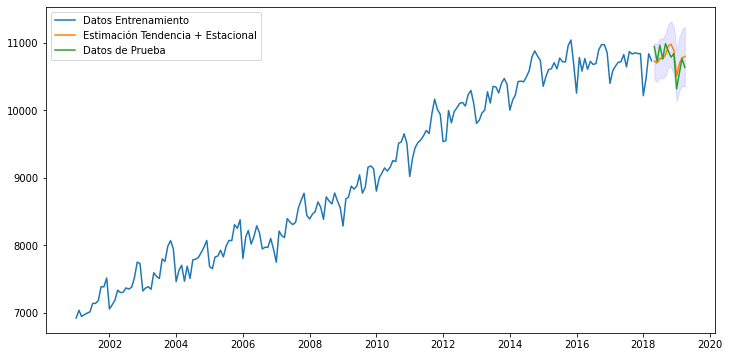

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.plot(data_test,label="Datos de Prueba")

plt.legend()
plt.show()

##3. auto ARIMA



### 3.1. ACF y PACF

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Series de Tiempo/Desempleo y empleo/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = data[["Ocupados"]][:train_len]
data.head()

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462


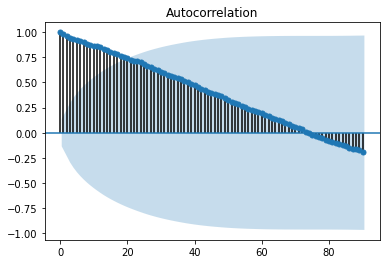

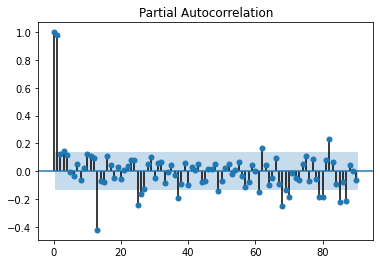

In [ ]:
plot_acf(data['Ocupados'],lags=90);
plot_pacf(data['Ocupados'],lags=90);

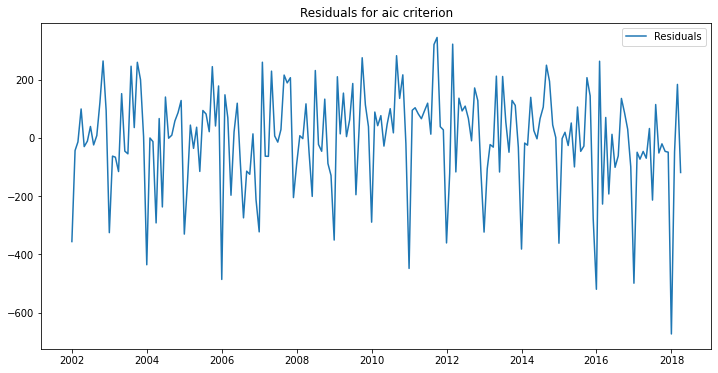

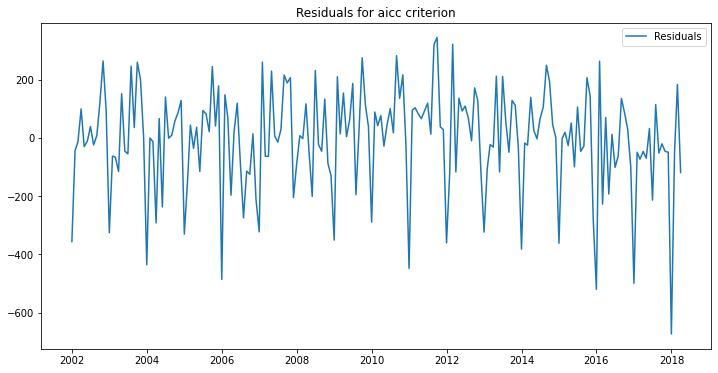

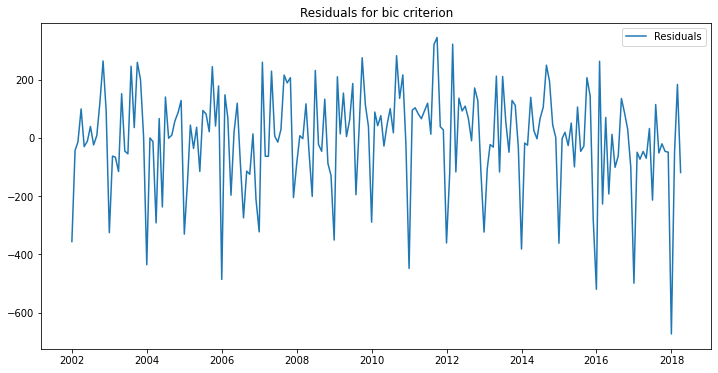

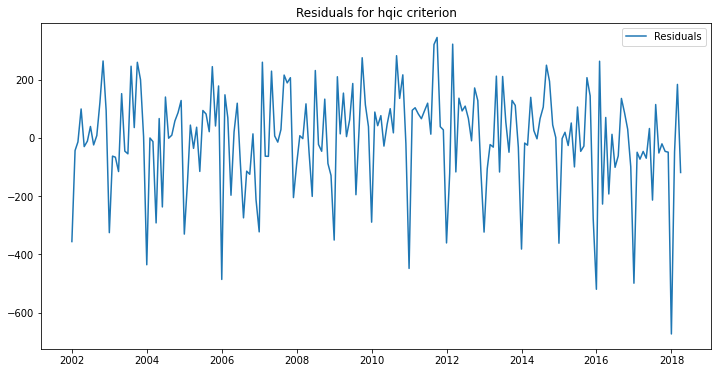

/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


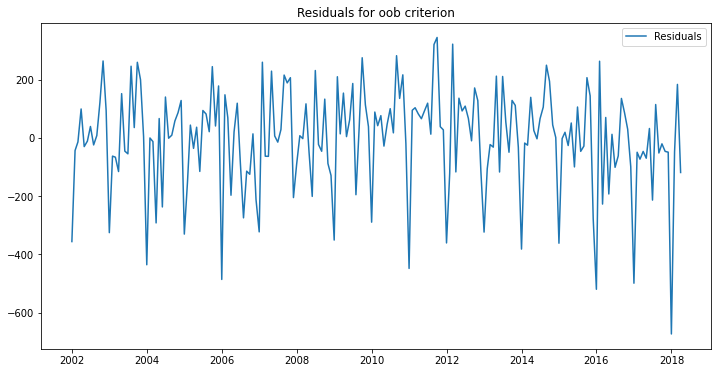

In [ ]:
criterions = ['aic', 'aicc', 'bic', 'hqic', 'oob']

# graficamos los residuales para cad criterio desde el anio 2002
for criterion in criterions:
    model = auto_arima(data["Ocupados"], max_p=10, max_q=10, information_criterion=(criterion))
    residuals = model.resid()
    
    start_year = 2002
    filtered_residuals = residuals[data.index.year >= start_year]
    
    fig = plt.figure(figsize=(12, 6))
    plt.title(f"Residuals for {criterion} criterion")
    plt.plot(filtered_residuals, label="Residuals")
    plt.legend()
    plt.show()
    
    model.summary()


In [ ]:
## information_criterion (‘aic’)
model = auto_arima(data["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1357.351
Date:                Mon, 13 Feb 2023   AIC                           2722.702
Time:                        03:24:35   BIC                           2736.033
Sample:                    01-01-2001   HQIC                          2728.093
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.0456      2.375      4.230      0.000       5.391      14.700
ar.L1          0.4628      0.100      4.630      0.000       0.267       0.659
ma.L1         -0.8755      0.052    -16.869      0.000      -0.977      -0.774
sigma2      2.882e+04   2511.774     11.475      0.000    2.39e+04    3.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                50.10
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.96
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Supuesto

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


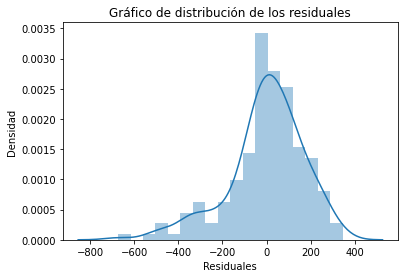

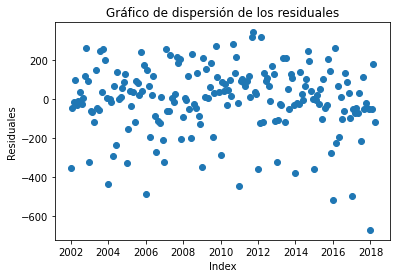

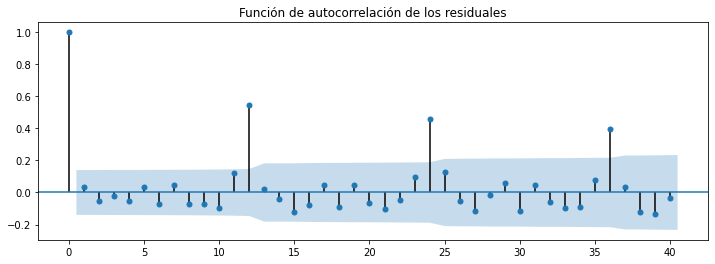

In [ ]:
check_regression_assumptions(filtered_residuals) # comprobando si los residuales cumplen los supuestos

### 3.2. Pronóstico del ARIMA(1,1,1) obtenido en el auto.arima

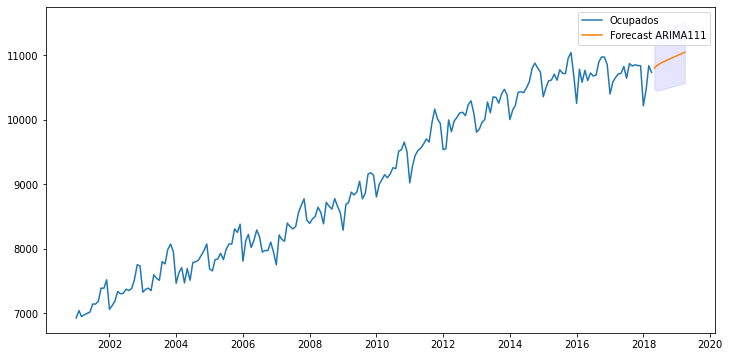

In [ ]:
h = 12

y_forec, conf_int = model.predict(h, return_conf_int=True, alpha=0.05)
preds111 = pd.DataFrame(np.column_stack([y_forec, conf_int[:, 0], conf_int[:, 1]]))
preds111.columns = ['Point_forecast', 'lower_95', 'upper_95']

start_date = data.index[-1]
forecast_dates = pd.date_range(start_date, periods=h, freq='M')

fig = plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Ocupados"], label="Ocupados")
plt.plot(forecast_dates, preds111['Point_forecast'], label="Forecast ARIMA111")

plt.fill_between(forecast_dates, preds111['lower_95'], preds111['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()


## 4. Comparando modelos con el mejor RMSE

In [ ]:
data_test = data_test.reset_index(drop=True)
preds['Point_forecast']

def rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
# RMSE del autoarima
rmse(data_test['Ocupados'],preds111['Point_forecast'])

289.15468332800793

In [ ]:
# RMSE de los modelos de Tendencia y estacionalidad
df

,RMSE,Polinomio
0,371.530109,2
1,147.335902,3
2,139.100863,4
3,132.671200,5
4,116.393323,6
5,1738.881270,7


## FULL train-Test

In [ ]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos 
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Series de Tiempo/Desempleo y empleo/datosEmpleo.xlsx",index_col='mes',parse_dates=True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


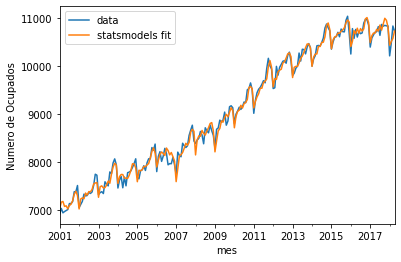

In [ ]:
ets_model = ETSModel(endog=data_train['Ocupados'] ,error="add",trend="add",seasonal="add")
ets_result = ets_model.fit()

fit = ets_model.fit(maxiter=10000)
data_train['Ocupados'].plot(label='data')
fit.fittedvalues.plot(label='statsmodels fit')
plt.ylabel("Numero de Ocupados");
plt.legend();

In [ ]:
## Se obtienen los hiperparametros

print(ets_result.alpha)
print(ets_result.beta)
print(ets_result.gamma)
print(ets_result.param_names)

0.5210294726964335
5.210294726964335e-05
4.7897052730356654e-05
['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend', 'initial_seasonal.0', 'initial_seasonal.1', 'initial_seasonal.2', 'initial_seasonal.3', 'initial_seasonal.4', 'initial_seasonal.5', 'initial_seasonal.6', 'initial_seasonal.7', 'initial_seasonal.8', 'initial_seasonal.9', 'initial_seasonal.10', 'initial_seasonal.11']


In [ ]:
## Ahora se ajusta el modelo final con todos los datos

s1 = pd.Series(data_train['Ocupados'], name='s1')
s2 = pd.Series(preds['Point_forecast'], name='s2')

concatenated_df = pd.concat([s1, s2], axis=0)
concatenated_df

final_model = ETSModel(endog=concatenated_df,error="add",trend="add",seasonal="add")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.5210294726964335,'smoothing_trend': 5.210294726964335e-05,'smoothing_seasonal':4.7897052730356654e-05})

print(final_model_fit.alpha)
print(final_model_fit.beta)
print(final_model_fit.gamma)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5210294726964335
5.210294726964335e-05
4.7897052730356654e-05
